# Construcción de tu Primer Clasificador de Imágenes

¡Bienvenido a este laboratorio práctico donde construirás, entrenarás y evaluarás tu primer clasificador de imágenes usando PyTorch! Ya has aprendido los conceptos básicos detrás del pipeline de aprendizaje profundo (deep learning), y ahora es el momento de poner ese conocimiento en práctica. Tu objetivo ahora es crear una red neuronal que pueda reconocer dígitos escritos a mano del conjunto de datos MNIST.

Al final de este notebook, habrás pasado por todo el proceso de extremo a extremo. Específicamente, lograrás:
- Preparar tus datos: Cargar el conjunto de datos MNIST, inspeccionar su formato y aplicar transformaciones esenciales.  
- Construir tu modelo: Definir una red neuronal personalizada utilizando la clase flexible nn.Module de PyTorch.  
- Entrenar tu modelo: Implementar el proceso de entrenamiento completo con una función de pérdida, un optimizador y un bucle de entrenamiento.  
- Analizar tus resultados: Evaluar tu modelo con datos no vistos y visualizar su rendimiento.



¡Comencemos!

## Imports

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import helper_utils

* El código a continuación selecciona el mejor hardware disponible en tu sistema para acelerar el entrenamiento del modelo.
    * **CUDA**: Se ejecuta en GPUs NVIDIA, que son ampliamente utilizadas para el aprendizaje profundo y suelen ofrecer el rendimiento de entrenamiento más rápido. 
    * **MPS**: Se ejecuta en las GPUs de Apple Silicon, proporcionando una aceleración eficiente en sistemas Mac modernos.
    * **CPU**: Se ejecuta en la Unidad Central de Procesamiento (Central Processing Unit), el procesador estándar que tiene cada computadora. PyTorch la utilizará automáticamente si no se detecta una GPU compatible. 

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

Using device: CPU


## Conjunto de Datos MNIST: Preparando tus Datos

El [conjunto de datos MNIST](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) es un referente clásico para la clasificación de imágenes y a menudo se considera el "hola mundo" de la visión por computadora. Contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Cada imagen es de 28 por 28 píxeles, en escala de grises, y muestra un único dígito escrito a mano del 0 al 9.

Antes de que un modelo pueda aprender de estos datos, es necesario convertir las imágenes en números que una red neuronal pueda procesar. Cada píxel se convierte en un valor numérico que representa su brillo y, juntos, estos números forman un **tensor**, que es el formato que los modelos de PyTorch utilizan para el cálculo. Las redes neuronales entrenan mejor cuando estos valores de entrada son pequeños y están centrados alrededor de cero, ya que esto ayuda a que los gradientes fluyan con mayor suavidad y hace que el aprendizaje sea más estable. Para lograr esto, deberás **normalizar** los valores de los píxeles para que caigan dentro de ese rango.

Para ver exactamente qué significa esto, comenzarás cargando los datos de entrenamiento de MNIST directamente desde `torchvision`, la biblioteca de PyTorch para tareas de visión por computadora. Aún no aplicarás ninguna transformación. En su lugar, inspeccionarás una imagen sin procesar para ver cómo lucen los datos antes de cualquier cambio y, más adelante, compararás cómo aparece esa misma imagen una vez preparada para el modelo.

- Define `data_path`, que especifica la carpeta donde se almacenará tu conjunto de datos.

In [3]:
# Set the path to store the dataset files
data_path = "./data"

* Carga el conjunto de datos MNIST usando `torchvision.datasets.MNIST`.
    * `root`: Esto le indica a PyTorch dónde guardar los archivos del dataset. En este caso, en la ubicación del `data_path` que acabas de definir.
    * `train`: Establecer esto en `True` asegura que obtengas la partición de entrenamiento (training split) del dataset, que contiene 60,000 imágenes.
    * `download`: Este práctico parámetro le indica a PyTorch que descargue automáticamente los archivos si aún no están presentes en tu carpeta raíz (root folder).

In [4]:
train_dataset_without_transform = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=True,         # Specify that you want the training split of the dataset
    download=True       # Download the data if it's not found in the root directory
)

100.0%
100.0%
100.0%
100.0%


<br>

Ahora que has cargado el dataset, puedes inspeccionar un elemento individual de este.

* Puedes recuperar cualquier muestra de tu objeto `Dataset` como si fuera una lista de Python usando su índice. Aquí, accederás al primer elemento en el índice `0`.
* Observa que cada elemento es una **tuple** (tupla) que contiene dos partes: los datos de la imagen y su etiqueta (label) numérica correspondiente.
* Después de ejecutar el código, deberías ver lo siguiente:
    * La imagen es un objeto **PIL Image**, un formato de Python común para datos de imagen.
    * Sus dimensiones son **(28, 28)**, lo que coincide con el tamaño de imagen de MNIST.
    * La etiqueta (label) es un entero que representa el dígito mostrado en la imagen.
    
> **Una Nota sobre las Etiquetas (Labels)**: 
>
>    Los datasets en PyTorch devuelven las etiquetas como **numerical indices**, no como texto. Para el **MNIST dataset**, esto es directo: el índice `0` representa el dígito `0`, el índice `1` representa el dígito `1`, y así sucesivamente.
>
>    Esta relación entre los índices de las etiquetas y sus significados es menos directa en otros datasets. Por ejemplo, si estuvieras trabajando con imágenes de gatos y perros, las etiquetas seguirían siendo 0 y 1, no las palabras "cat" o "dog". En esos casos, podrías crear una lista como `class_names = ['cat', 'dog']` para mapear los índices numéricos de nuevo a nombres legibles al mostrar resultados o hacer debugging.

In [5]:
# Get the first sample (index 0), as a (image, label) tuple
image_pil, label = train_dataset_without_transform[0] # Get the first image
    
print(f"Image type:        {type(image_pil)}")
# Since `image_pil` is a PIL Image object, its dimensions are accessed using the .size attribute.
print(f"Image Dimensions:  {image_pil.size}")
print(f"Label Type:        {type(label)}")
print(f"Label value:       {label}")

Image type:        <class 'PIL.Image.Image'>
Image Dimensions:  (28, 28)
Label Type:        <class 'int'>
Label value:       5


#### Visualización de un Dígito sin Procesar (Raw Digit)

Ahora, visualizarás la imagen original (raw image) que acabas de cargar. La función auxiliar `display_image` muestra la imagen junto con una cuadrícula (grid) de los valores numéricos de los píxeles.

* Ejecuta la celda de código de abajo para mostrar la imagen.
* Observa la barra de color a la derecha, que muestra el rango completo de los posibles valores de brillo para un píxel, de **0** a **255**. Así es como se ven los datos *antes* de cualquier normalización.
* Cada número superpuesto en el dígito representa el brillo de ese píxel individual. En una imagen en escala de grises, **0** corresponde al negro puro, **255** al blanco puro, y los valores intermedios son tonalidades de gris.
    * Puedes intentar ejecutar la función de nuevo con `show_values=False` para ver la imagen sin la cuadrícula numérica.

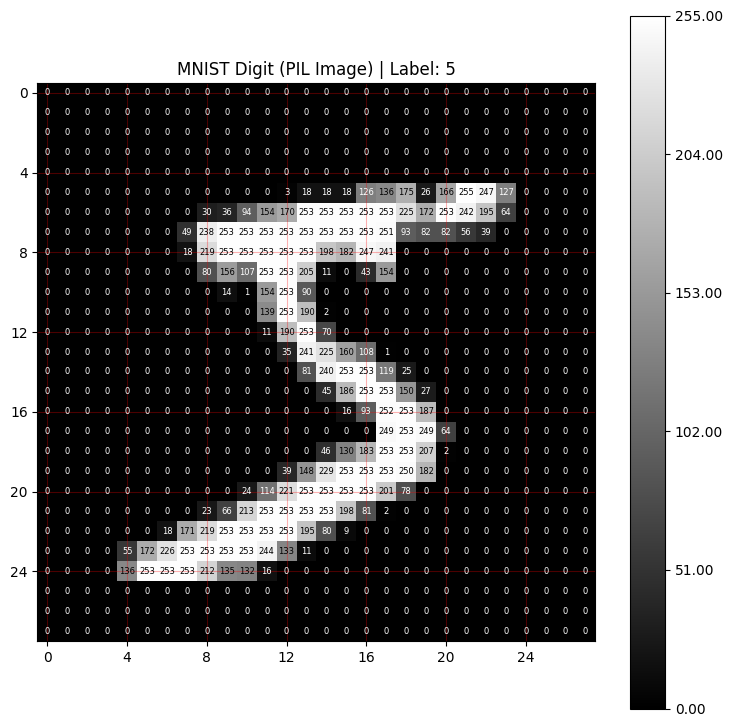

In [6]:
# Visualize the sample image and its corresponding label
helper_utils.display_image(image_pil, label, "MNIST Digit (PIL Image)", show_values=True)

### El Efecto de las Transformaciones (The Effect of Transformations)

Ya has visto los datos sin procesar: una **PIL image** estándar con valores de píxeles que van de 0 a 255. A continuación, prepararás los datos para el modelo aplicando transformaciones y verás cómo estos pasos cambian la estructura y los valores numéricos de la imagen.

#### Transformaciones (Transformations)

Usarás [transforms.Compose](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) para encadenar una secuencia de pasos de preparación que se aplican a cada imagen a medida que se carga. Para esta tarea, utilizarás dos de las transformaciones más comunes:

* [transforms.ToTensor()](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html): Convierte la imagen PIL en un tensor de PyTorch y reescala sus valores de píxeles del rango original 0–255 a valores entre 0 y 1.
* [transforms.Normalize()](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html): Ajusta aún más los valores del tensor centrándolos alrededor de cero, utilizando la media (mean) y la desviación estándar (standard deviation) calculadas a partir del dataset MNIST. Esto hace que los datos sean más consistentes y ayuda a que el modelo aprenda más rápido y de manera más confiable.

In [7]:
# Convert images to tensors and normalize pixel values
# Pixel values are scaled to [0, 1] and then standardized to mean 0 and std 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

Ahora cargarás el dataset nuevamente, esta vez aplicando las transformaciones que acabas de definir. El código es casi idéntico al anterior, con una adición importante.

* El argumento `transform` se asigna al objeto `transform` que creaste anteriormente. Esto le indica al `Dataset` que aplique automáticamente tu secuencia de transformaciones (`ToTensor` y `Normalize`) a cada imagen a medida que se carga.

In [8]:
train_dataset = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=True,         # Specify that you want the training split of the dataset
    download=True,      # Download the data if it's not found in the root directory
    transform=transform # Apply the defined transformations to each image
)

Accedamos al mismo elemento nuevamente, esta vez desde el dataset con las transformaciones aplicadas. Observa las diferencias clave en el resultado:

* La imagen ya no es una PIL Image porque la transformación `ToTensor` la ha convertido en un `torch.Tensor`, el formato que requieren los modelos de PyTorch.
* La forma (shape) ahora es `(1, 28, 28)`. PyTorch estructura los tensores de imagen como `[channels, height, width]`. Dado que las imágenes están en escala de grises, solo hay un canal (channel).

In [9]:
# Access the first item again
image_tensor, label = train_dataset[0]

print(f"Image Type:                   {type(image_tensor)}")
# Since the `image` is now a PyTorch Tensor, its dimensions are accessed using the .shape attribute.
print(f"Image Shape After Transform:  {image_tensor.shape}")
print(f"Label Type:                   {type(label)}")
print(f"Label value:                  {label}")

Image Type:                   <class 'torch.Tensor'>
Image Shape After Transform:  torch.Size([1, 28, 28])
Label Type:                   <class 'int'>
Label value:                  5


#### Visualización de un Dígito Transformado (Visualizing a Transformed Digit)

Ahora puedes visualizar el mismo dígito nuevamente, pero esta vez después de que se hayan aplicado las transformaciones.

* Observa de cerca los valores de los píxeles. Ya no están en el rango 0-255. La transformación Normalize ha desplazado estos valores para que ahora estén **centrados alrededor de cero**, dando un nuevo rango de aproximadamente **-0.42** a **2.82**.
* La barra de color a la derecha confirma este cambio. Los píxeles que originalmente eran oscuros (valores bajos) ahora tienen números negativos, mientras que los píxeles brillantes tienen valores positivos grandes.
    * Puedes intentar ejecutar la función de nuevo con `show_values=False` para ver la imagen sin la cuadrícula numérica.
    
Este proceso de normalización es un paso clave en la preparación de datos para una red neuronal. Mantiene los valores de input consistentes y ayuda al modelo a entrenar de manera más efectiva.

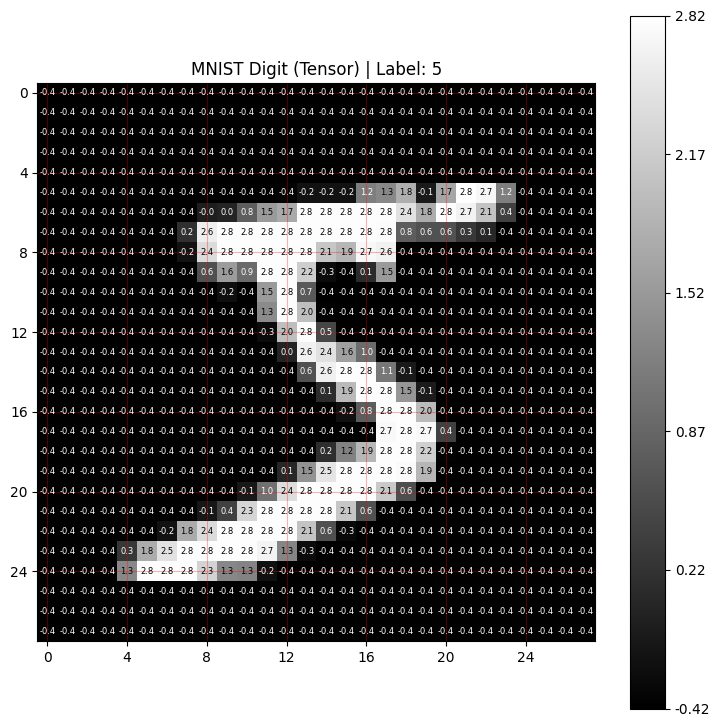

In [10]:
# Visualize the transformed image and its label
helper_utils.display_image(image_tensor, label, "MNIST Digit (Tensor)", show_values=True)

### Completando el Pipeline de Datos (Completing the Data Pipeline)

Ya has visto cómo las transformaciones preparan tus imágenes originales (raw images) para el entrenamiento. Ahora es el momento de completar el pipeline de datos creando un dataset de prueba y envolviendo ambos conjuntos de datos con un DataLoader.

#### Cargar el Dataset de Prueba (Load the Test Dataset)

Además de los datos de entrenamiento, necesitas un dataset separado para pruebas que el modelo nunca haya visto antes. Esto te permite evaluar qué tan bien generaliza el modelo ante nuevos ejemplos.

* Cargarás el conjunto de prueba usando la misma función `torchvision.datasets.MNIST` que antes, pero con una diferencia clave: establece `train=False` para especificar que deseas las 10,000 imágenes de prueba.

In [11]:
test_dataset = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=False,        # Specify that you want the testing split of the dataset
    download=True,      # Download the data if it's not found in the root directory
    transform=transform # Apply the defined transformations to each image
)

#### Crear los Data Loaders (Create Data Loaders)

El paso final en tu pipeline de datos es crear instancias de [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders). Un `DataLoader` toma tu `Dataset` y lo entrega en trozos manejables llamados **batches**. Esto es esencial para entrenar con datasets grandes, ya que evita cargar todos los datos en la memoria a la vez.

* **Training Loader**: Para el conjunto de entrenamiento, usa un `batch_size` de 64 y establece `shuffle=True`. Barajar los datos (shuffling) es crítico durante el entrenamiento porque aleatoriza el orden de las muestras en cada pasada (epoch). Esto evita que el modelo memorice patrones en el orden del dataset y ayuda a que generalice mejor.

* **Test Loader**: Para el conjunto de pruebas, puedes usar un tamaño de batch mucho mayor (por ejemplo, 1000) ya que no se calculan gradientes durante la evaluación. Esto ahorra memoria y acelera las pruebas. Establecerás `shuffle=False` porque el orden de los datos no importa cuando solo estás midiendo el rendimiento final del modelo.

In [13]:
# Create a data loader for the training set with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create a data loader for the test set with a larger batch size and no shuffling
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Construcción del Modelo de Red Neuronal (Building the Neural Network Model)

Con tu pipeline de datos completado, es hora de definir la arquitectura de la red neuronal. Crearás un modelo personalizado mediante una clase que hereda de [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) de PyTorch. Este patrón es flexible y te otorga un control total sobre la estructura del modelo.

Cada clase `nn.Module` tiene dos partes esenciales:

* El método `__init__` es donde defines e inicializas las capas (layers) que usará tu modelo, como si estuvieras reuniendo tus herramientas antes de empezar un trabajo.
* El método `forward` es donde defines la ruta exacta que toman los datos (data path) a medida que fluyen a través de esas capas.



### Definir el Modelo (Define the Model)

La arquitectura de tu modelo incluirá los siguientes componentes clave:

* [nn.Flatten()](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.flatten.Flatten.html): El trabajo de esta capa es transformar los datos de la imagen 2D (28x28 píxeles) en un vector 1D de 784 elementos (28 * 28 = 784). Este paso de reformateo (reshaping) es obligatorio antes de pasar los datos a las capas lineales, que esperan vectores planos en lugar de cuadrículas.

* [nn.Linear()](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html): Estas son las capas principales de tu red. La primera capa lineal mapeará los 784 píxeles de input a 128 características ocultas (hidden features), y la segunda mapeará esas 128 características a 10 clases de output, una por cada clase de dígito (0-9).

* [nn.ReLU()](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html): Esta es tu función de activación. Introduce no-linealidad, permitiendo que el modelo aprenda patrones complejos que las transformaciones lineales simples no pueden capturar.

In [14]:
class SimpleMNISTDNN(nn.Module):
    """
    Un modelo de red neuronal profunda simple para el dataset MNIST.

    Este modelo consta de una capa de aplanado (flatten layer) seguida de dos capas lineales
    con una función de activación ReLU. Está diseñado para tareas de clasificación
    en imágenes en escala de grises de 28x28.
    """
   
    def __init__(self):
        """
        Initializes the layers of the neural network.
        """
        super(SimpleMNISTDNN, self).__init__()
        # Initializes a layer to flatten the input tensor.
        # 28x28 input image to a 784-dimensional vector.
        self.flatten = nn.Flatten()
        # Initializes the sequential layers of the neural network
        self.layers = nn.Sequential(
            # Defines the first linear layer with 784 input features and 128 output features.
            nn.Linear(784, 128),
            # Applies the rectified linear unit activation function.
            nn.ReLU(),
            # Defines the second linear layer with 128 input features and 10 output features.
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Define el forward pass del modelo.

        Args:
            x: El tensor de entrada (input tensor).

        Returns:
            El tensor de salida (output tensor) después de pasar por las capas de la red.
        """
        # Flattens the input tensor.
        x = self.flatten(x)
        # Passes the flattened tensor through the sequential layers.
        x = self.layers(x)
        return x    

## Entrenando el Modelo (Training the Model)

Has preparado los datos y definido la arquitectura del modelo. Sin embargo, en este punto el modelo no está entrenado, por lo que sus predicciones serán conjeturas al azar.

En esta sección, le darás vida al modelo entrenándolo con los datos de MNIST. Esto implica configurar las herramientas necesarias (una función de pérdida y un optimizador), definir la lógica de entrenamiento y evaluación, y ejecutar el bucle de entrenamiento principal.


### Inicializar el Modelo, la Función de Pérdida y el Optimizador

Antes del entrenamiento, configura tres componentes esenciales:

* **El Modelo**: Primero, crearás una instancia de la clase SimpleMNISTDNN que definiste anteriormente. 
    * Como viste en las clases, es esencial que el modelo y los datos estén en el mismo dispositivo (device) para evitar errores. En este notebook, manejarás esto dentro de la propia función de entrenamiento. Al mover tanto el modelo como los datos al `device` dentro de esa función, garantizas que estén colocados correctamente justo antes de que ocurra cualquier cálculo.

* **La Función de Pérdida (Loss Function)**: Usarás [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) como tu función de pérdida. Esta es la elección estándar para tareas de clasificación multiclase como MNIST porque está diseñada específicamente para medir el error cuando un modelo debe elegir una clase entre varias posibilidades (es decir, un dígito del 0 al 9).



* **El Optimizador (Optimizer)**: Usarás [optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), un optimizador popular y altamente efectivo. El trabajo del optimizador es actualizar los pesos (weights) del modelo para minimizar la pérdida. `Adam` es conocido por adaptar la tasa de aprendizaje (learning rate) a medida que entrena, lo que a menudo ayuda a que el modelo aprenda de manera más rápida y confiable que otros optimizadores.

In [15]:
# Initialize the neural network model
model = SimpleMNISTDNN()

# Define the loss function, suitable for multi-class classification
loss_function = nn.CrossEntropyLoss()

# Set up the Adam optimizer to update the model's parameters with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Definir la Función de Entrenamiento (Define the Training Function)

Esta función encapsula toda la lógica para una **single training epoch** (época única de entrenamiento), que es una pasada completa por el dataset. Cada iteración sobre un **single batch** (lote individual) de datos dentro de esa época se denomina **step** (paso). Como recordatorio, esta función realiza estas operaciones clave:

* **Preparación del Modelo (Model Preparation)**: Antes de iterar sobre los datos, prepara el modelo moviéndolo al `device` correcto y configurándolo en modo de entrenamiento con `model.train()`.



* **Bucle Central de Entrenamiento (Core Training Loop)**: Para cada batch de datos, ejecuta la secuencia esencial de entrenamiento de cinco pasos: limpiar gradientes, ejecutar un forward pass, calcular la pérdida (loss), realizar la retropropagación (backpropagation) y actualizar los pesos (weights) del modelo.

* **Informe de Progreso (Progress Reporting)**: Finalmente, realiza un seguimiento de la pérdida acumulada (running loss) y la precisión (accuracy), imprimiendo actualizaciones periódicas para monitorear qué tan bien está aprendiendo el modelo.
    * Específicamente, con **60,000** imágenes de entrenamiento y un batch size de **64**, la función informará su progreso cada **134 steps**, dándote **7** actualizaciones constantes a lo largo de la época.

In [ ]:
def train_epoch(model, loss_function, optimizer, train_loader, device):
    """
    Entrena un modelo de PyTorch durante una única época (epoch).

    Esta función itera sobre el conjunto de datos de entrenamiento, realiza los
    pases forward y backward, y actualiza los pesos (weights) del modelo. También
    rastrea e imprime la pérdida (loss) y la precisión (accuracy) en intervalos especificados.

    Args:
        model: El modelo de red neuronal que se va a entrenar.
        loss_function: La función de pérdida utilizada para calcular el error.
        optimizer: El optimizador utilizado para actualizar los pesos del modelo.
        train_loader: El DataLoader que proporciona los batches de datos de entrenamiento.
        device: El dispositivo (e.g., 'cuda', 'mps' o 'cpu') en el que se realizará el entrenamiento.

    Returns:
        Una tupla que contiene:
        - model: El modelo después de entrenar por una época.
        - avg_epoch_loss: La pérdida promedio calculada sobre todos los batches de la época.
    """
    # Movemos el modelo al dispositivo especificado
    model = model.to(device)
    # Ponemos el modelo en modo de entrenamiento
    model.train()
    
    # Inicializamos los acumuladores para la pérdida total de la época
    epoch_loss = 0.0
    
    # Inicializamos los acumuladores para el reporte periódico de progreso
    running_loss = 0.0
    num_correct_predictions = 0
    total_predictions = 0
    total_batches = len(train_loader)

    # Iteramos sobre los datos de entrenamiento en batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Movemos el batch actual de datos al dispositivo especificado
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Clear any gradients from the previous iteration
        optimizer.zero_grad()
        
        # Perform a forward pass to get model predictions
        outputs = model(inputs)
        
        # Calculate the loss for the current batch
        loss = loss_function(outputs, targets)
        
        # Perform backpropagation to compute gradients
        loss.backward()
        
        # Update the model's weights based on the computed gradients
        optimizer.step()
        
        # Accumulate the loss for tracking and reporting
        loss_value = loss.item()
        epoch_loss += loss_value
        running_loss += loss_value
        
        # Calculate accuracy metrics for the current batch
        _, predicted_indices = outputs.max(1)
        batch_size = targets.size(0)
        total_predictions += batch_size
        num_correct_in_batch = predicted_indices.eq(targets).sum().item()
        num_correct_predictions += num_correct_in_batch

        # Check if it's time to print a progress update
        if (batch_idx + 1) % 134 == 0 or (batch_idx + 1) == total_batches:
            # Calculate average loss and accuracy for the current interval
            avg_running_loss = running_loss / 134
            accuracy = 100. * num_correct_predictions / total_predictions
            
            # Print the progress update
            print(f'\tStep {batch_idx + 1}/{total_batches} - Loss: {avg_running_loss:.3f} | Acc: {accuracy:.2f}%')
            
            # Reset the trackers for the next reporting interval
            running_loss = 0.0
            num_correct_predictions = 0
            total_predictions = 0
            
    # Calculate the average loss for the entire epoch
    avg_epoch_loss = epoch_loss / total_batches
    # Return the trained model and the average epoch loss
    return model, avg_epoch_loss

### Definir la Función de Evaluación (Define the Evaluation Function)

Después de entrenar tu modelo, necesitas una forma de medir su rendimiento con datos que nunca ha visto antes. Mientras que el proceso de entrenamiento muestra qué tan bien está aprendiendo el modelo los datos de entrenamiento, `evaluate` revela si puede generalizar ese aprendizaje a nuevos ejemplos. Es similar al bucle de entrenamiento pero optimizado para la inferencia, con algunas diferencias clave:

* **Configuración para Inferencia (Setup for Inference)**: El modelo se configura en modo de evaluación con `model.eval()` y los cálculos de gradientes se desactivan usando un bloque `torch.no_grad()`. Estos pasos son esenciales para obtener resultados correctos y hacen que el proceso sea más rápido y eficiente en el uso de memoria.



* **Forward Pass Simplificado**: El bucle es mucho más simple que en el entrenamiento. Solo realiza un forward pass para obtener las predicciones del modelo y calcular la precisión (accuracy). No hay cálculos de pérdida (loss), retropropagación (backpropagation) ni actualizaciones de pesos con un optimizador.

In [22]:
def evaluate(model, test_loader, device):
    """
    Evalúa la precisión (accuracy) del modelo en un conjunto de datos de prueba.

    Esta función pone el modelo en modo de evaluación, itera a través de los datos
    de prueba y calcula el porcentaje de predicciones correctas.

    Args:
        model: El modelo de red neuronal que se va a evaluar.
        test_loader: Un data loader que contiene el dataset de prueba.
        device: El dispositivo (e.g., 'cpu' o 'cuda') en el que se ejecutará la evaluación.

    Returns:
        La precisión (accuracy) del modelo en el dataset de prueba expresada como porcentaje.
    """
    # Sets the model to evaluation mode.
    model.eval()
    # Initializes a counter for correct predictions.
    num_correct_predictions = 0
    # Initializes a counter for the total number of predictions.
    total_predictions = 0

    # Disables gradient calculation to reduce memory usage and speed up computations.
    with torch.no_grad():
        # Iterates over all batches in the test data loader.
        for inputs, targets in test_loader:
            # Moves the input data and targets to the specified device.
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Performs a forward pass to get the model's output.
            outputs = model(inputs)
            
            # Retrieves the index of the highest value in the output tensor, which represents the predicted class.
            _, predicted_indices = outputs.max(1)
            
            # Gets the size of the current batch.
            batch_size = targets.size(0)
            # Adds the batch size to the total number of predictions.
            total_predictions = total_predictions + batch_size
            
            # Compares the predicted indices with the actual target values.
            correct_predictions = predicted_indices.eq(targets)
            # Sums the correct predictions in the current batch.
            num_correct_in_batch = correct_predictions.sum().item()
            # Adds the correct predictions from the current batch to the total count.
            num_correct_predictions = num_correct_predictions + num_correct_in_batch

    # Calculates the overall accuracy as a percentage.
    accuracy_percentage = (num_correct_predictions / total_predictions) * 100
    # Prints the calculated accuracy to the console.
    print((f'\tAccuracy - {accuracy_percentage:.2f}%'))
    
    return accuracy_percentage

### El Bucle de Entrenamiento (The Training Loop)

Aquí es donde todos los componentes que has construido se unen para entrenar el modelo. El bucle se ejecuta durante un número determinado de épocas (epochs), donde cada época representa una pasada completa por todo el dataset. Entrenar durante múltiples épocas permite que el modelo vea los datos repetidamente, ajustando gradualmente sus pesos (weights) internos para mejorar la precisión.

La lógica dentro de cada época es directa y sigue un patrón estándar:

* Primero, llamas a la función `train_epoch` para entrenar el modelo con todos los datos de entrenamiento.

* Inmediatamente después, llamas a la función `evaluate` para medir el rendimiento del modelo con los datos de prueba (test data) no vistos. Este es un paso vital para comprobar si el modelo realmente está aprendiendo a **generalizar** o si solo está memorizando el conjunto de entrenamiento.

Finalmente, la pérdida (loss) y la precisión (accuracy) de cada época se almacenan en listas para que puedas analizar el progreso del modelo a lo largo del tiempo.

In [23]:
# Set the total number of training epochs (Feel free to set a different number)
num_epochs = 5

# Initialize lists to store metrics from each epoch for later analysis
train_loss = []
test_acc = []

# Begin the training and evaluation process
for epoch in range(num_epochs):
    print(f'\n[Training] Epoch {epoch+1}:')
    # Call the training function to train the model for one epoch
    trained_model, loss = train_epoch(model, loss_function, optimizer, train_loader, device)
    # Store the average training loss for the epoch
    train_loss.append(loss)
    
    print(f'[Testing] Epoch {epoch+1}:')
    # Call the evaluation function to measure performance on the test set
    accuracy = evaluate(trained_model, test_loader, device)
    # Store the test accuracy for the epoch
    test_acc.append(accuracy)


[Training] Epoch 1:
	Step 134/938 - Loss: 0.558 | Acc: 83.94%
	Step 268/938 - Loss: 0.300 | Acc: 91.34%
	Step 402/938 - Loss: 0.250 | Acc: 92.57%
	Step 536/938 - Loss: 0.201 | Acc: 94.19%
	Step 670/938 - Loss: 0.185 | Acc: 94.41%
	Step 804/938 - Loss: 0.176 | Acc: 94.76%
	Step 938/938 - Loss: 0.148 | Acc: 95.73%
[Testing] Epoch 1:
	Accuracy - 95.87%

[Training] Epoch 2:
	Step 134/938 - Loss: 0.117 | Acc: 96.60%
	Step 268/938 - Loss: 0.120 | Acc: 96.64%
	Step 402/938 - Loss: 0.125 | Acc: 96.18%
	Step 536/938 - Loss: 0.097 | Acc: 96.98%
	Step 670/938 - Loss: 0.111 | Acc: 96.71%
	Step 804/938 - Loss: 0.110 | Acc: 96.84%
	Step 938/938 - Loss: 0.100 | Acc: 96.92%
[Testing] Epoch 2:
	Accuracy - 97.14%

[Training] Epoch 3:
	Step 134/938 - Loss: 0.076 | Acc: 97.66%
	Step 268/938 - Loss: 0.081 | Acc: 97.59%
	Step 402/938 - Loss: 0.067 | Acc: 97.85%
	Step 536/938 - Loss: 0.090 | Acc: 97.29%
	Step 670/938 - Loss: 0.072 | Acc: 97.82%
	Step 804/938 - Loss: 0.071 | Acc: 97.83%
	Step 938/938 - Loss:

## Analizando el Rendimiento del Modelo (Analyzing Model Performance)

Con el entrenamiento completado, el paso final es analizar el rendimiento de tu modelo. Lo harás de dos maneras: **cualitativamente**, observando algunas de sus predicciones específicas, y **cuantitativamente**, graficando sus métricas de rendimiento a lo largo del tiempo.

### Visualizando Predicciones (Visualizing Predictions)

Ahora que el modelo está entrenado, veámoslo en acción. Una excelente manera de tener una idea de su rendimiento es visualizar las predicciones que realiza sobre muestras aleatorias del conjunto de prueba (test set). Esto te permite ver ejemplos concretos de dónde tiene éxito el modelo y dónde podría estar cometiendo errores.

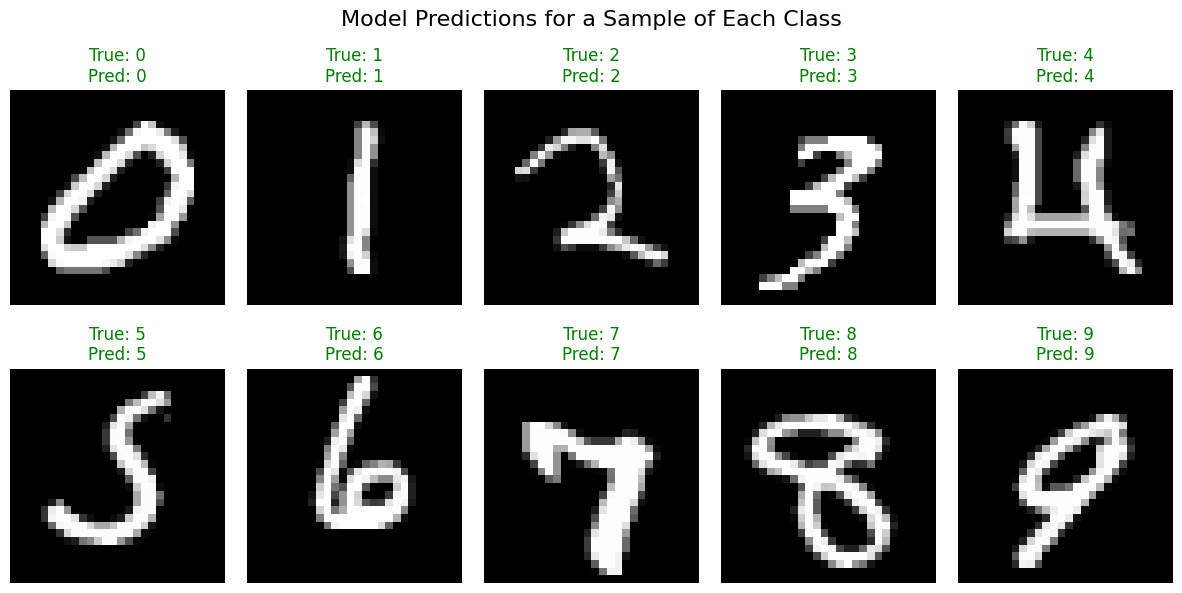

In [24]:
# Visualize model predictions on a random sample of test images
helper_utils.display_predictions(trained_model, test_loader, device)

### Graficando las Métricas de Rendimiento (Plotting Performance Metrics)

Observar predicciones individuales puede ser útil, pero visualizar el rendimiento general te da una visión más clara de cómo progresó el entrenamiento. Graficar la pérdida de entrenamiento (training loss) y la precisión de prueba (test accuracy) a lo largo de las épocas te ayuda a evaluar qué tan eficazmente aprendió el modelo.

* **Pérdida de Entrenamiento (Training Loss)**: Este gráfico debería mostrar una tendencia constante hacia abajo, lo que indica que el modelo está aprendiendo de los datos de entrenamiento y reduciendo su error con el tiempo.

* **Precisión de Prueba (Test Accuracy)**: Este gráfico debería mostrar una tendencia ascendente a medida que el modelo mejora su capacidad para generalizar ante datos nuevos y no vistos. Una precisión de prueba en aumento indica que el modelo no solo está memorizando el conjunto de entrenamiento, sino que realmente está aprendiendo patrones que se transfieren a nuevos ejemplos. Cuando la curva comienza a aplanarse, a menudo significa que el modelo ha aprendido todo lo que puede con la configuración actual.

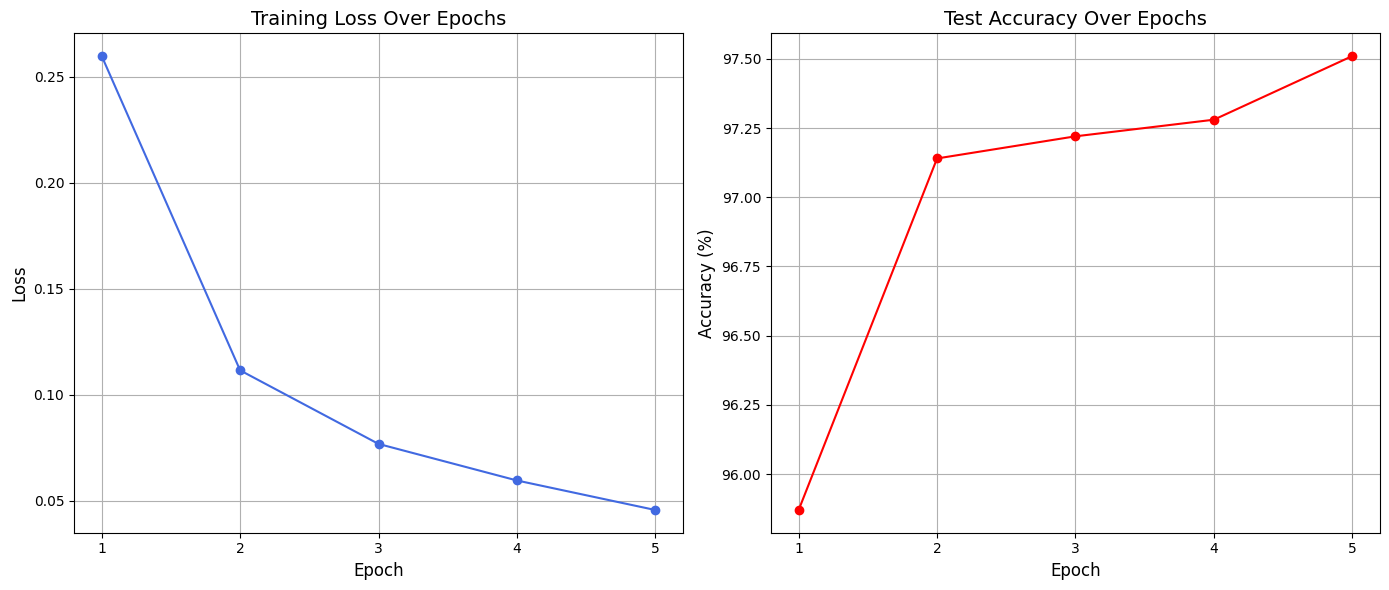

In [25]:
# Plot the training loss and test accuracy curves over all epochs
helper_utils.plot_metrics(train_loss, test_acc)

# Conclusión (Conclusion)

¡Felicidades por completar el laboratorio! Has navegado con éxito por todo el pipeline de aprendizaje automático (machine learning) para construir, entrenar y analizar tu propio clasificador de imágenes.

Comenzaste con datos de imagen sin procesar (raw image data) y viste de primera mano por qué la preparación de datos (**data preparation**), transformando y normalizando tus inputs, es un primer paso tan fundamental. Luego, construiste una arquitectura de red neuronal personalizada, practicando con la potencia y flexibilidad de **`nn.Module`**.

Lo más importante es que implementaste el bucle de entrenamiento central (**core training loop**), el motor que impulsa el proceso de aprendizaje, y utilizaste una función de evaluación (**evaluation function**) separada para obtener una medida honesta de la capacidad de tu modelo para generalizar ante datos nuevos y no vistos. Los gráficos finales de pérdida (loss) y precisión (accuracy) proporcionaron una historia cuantitativa clara del viaje de tu modelo, desde las conjeturas al azar hasta el reconocimiento preciso.

Las habilidades que has practicado aquí forman la base para abordar desafíos más avanzados de aprendizaje profundo (deep learning) en el futuro. ¡Bien hecho!